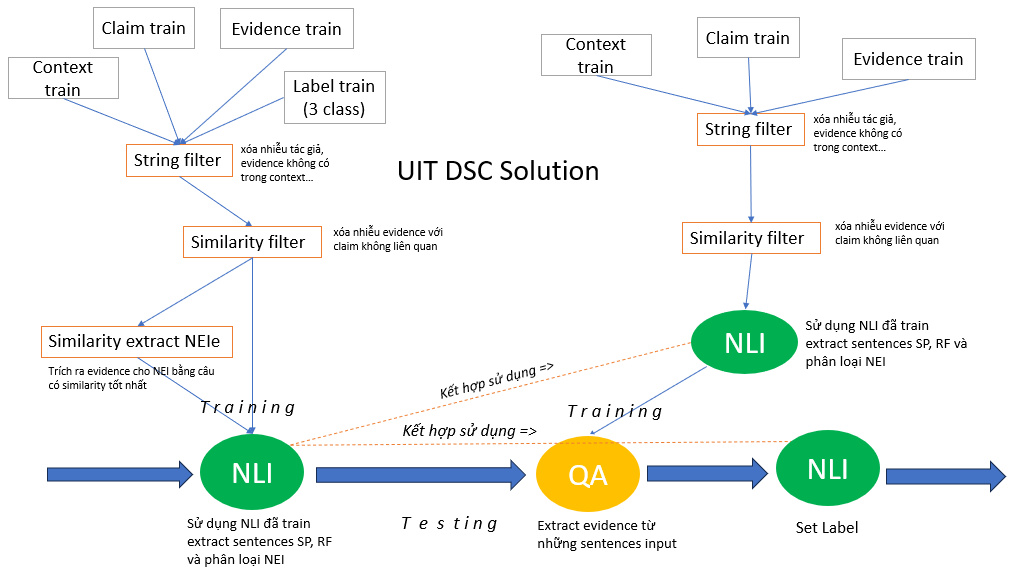

## Import lib

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/uitds-fever-ise-publist-test/ise-dsc01-public-test-offcial.json
/kaggle/input/uitds-fever-ise-publist-test/ise-dsc01-train.json
/kaggle/input/uitds-fever-ise-publist-test/ise-dsc01-train_new.json
/kaggle/input/uitds-fever-ise-publist-test/ISE-Train-Valid-Test/valid.csv
/kaggle/input/uitds-fever-ise-publist-test/ISE-Train-Valid-Test/train.csv
/kaggle/input/uitds-fever-ise-publist-test/ISE-Train-Valid-Test/test.csv
/kaggle/input/uitds-fever-ise-publist-test/ISE-Train-Valid-Test/small_train.csv
/kaggle/input/uitds-fever-ise-publist-test/ISE-Train-Valid-Test/small_train_balance.csv
/kaggle/input/uitds-fever-ise-publist-test/New-Balance-Data/valid.csv
/kaggle/input/uitds-fever-ise-publist-test/New-Balance-Data/small_test.csv
/kaggle/input/uitds-fever-ise-publist-test/New-Balance-Data/small_valid.csv
/kaggle/input/uitds-fever-ise-publist-test/New-Balance-Data/train.csv
/kaggle/input/uitds-fever-ise-publist-test/New-Balance-Data/test.csv
/kaggle/input/uitds-fever-ise-publist-tes

In [2]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from tqdm.auto import tqdm

In [3]:
# set random seed
myseed = 6666  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [4]:
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login
import wandb
user_secrets = UserSecretsClient()

my_wandb_secret = user_secrets.get_secret("wandb_api_key")
my_huggingface_secret = user_secrets.get_secret("huggingface-token-write")

wandb.login(key=my_wandb_secret)
login(token = my_huggingface_secret)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Load data

In [5]:
new_train_df = pd.read_csv('/kaggle/input/uitds-fever-ise-publist-test/New-Balance-Data/small_train.csv')
new_valid_df = pd.read_csv('/kaggle/input/uitds-fever-ise-publist-test/New-Balance-Data/small_valid.csv')
new_test_df = pd.read_csv('/kaggle/input/uitds-fever-ise-publist-test/New-Balance-Data/small_test.csv')

In [6]:
new_train_df['verdict'].value_counts()

verdict
SUPPORTED    2060
REFUTED      2052
NEI          1963
Name: count, dtype: int64

In [7]:
new_valid_df['verdict'].value_counts()

verdict
REFUTED      266
SUPPORTED    255
NEI          238
Name: count, dtype: int64

In [8]:
new_test_df['verdict'].value_counts()

verdict
REFUTED      261
SUPPORTED    260
NEI          239
Name: count, dtype: int64

## String filter

#### Xóa `\n` cái rồi tính tiếp:))


In [9]:
def remove_down_line(df):
    df['context'] = df['context'].apply(lambda x: x.replace('\n', ' '))
    df['claim'] = df['claim'].apply(lambda x: x.replace('\n', ' '))
    return df

In [10]:
new_train_df = remove_down_line(new_train_df)
new_valid_df = remove_down_line(new_valid_df)
new_test_df = remove_down_line(new_test_df)

#### Thêm evidence tạm cho NEI

In [11]:
def processing_evidence(data):
    data['evidence_train'] = ""  # Tạo cột 'evidence_train' trước
    for i in tqdm(range(len(data))):
        if data['verdict'][i] == "NEI":
            data.loc[i, 'evidence_train'] = data['context'][i].split('. ')[0]
        else:
            data.loc[i, 'evidence_train'] = data['evidence'][i]
    return data

In [12]:
train_df = processing_evidence(new_train_df)
valid_df = processing_evidence(new_valid_df)
test_df = processing_evidence(new_test_df)

  0%|          | 0/6075 [00:00<?, ?it/s]

  0%|          | 0/759 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

In [13]:
def remove_author(df):
    df = df[df['evidence_train'].apply(lambda x: len(x.split()) > 6)]
    return df

df_train = remove_author(train_df)
df_valid = remove_author(valid_df)
df_test = remove_author(test_df)

In [14]:
df_test['verdict'].value_counts()

verdict
REFUTED      261
SUPPORTED    254
NEI          235
Name: count, dtype: int64

In [15]:
df_train['verdict'].value_counts()

verdict
REFUTED      2036
SUPPORTED    2002
NEI          1950
Name: count, dtype: int64

#### Tiền xử lý dấu

In [16]:
import re

def preprocess_text(text: str) -> str:
    text = re.sub(r"['\"\?:\-!]", "", text)
    
    text = text.replace('\n', ' ')
    
    text = text.strip()
    text = " ".join(text.split())
#     text = text.lower()
    return text

In [17]:
def remove_punctuation_for_dataframe(df):
    df.loc[:, 'context'] = df['context'].apply(preprocess_text)
    df.loc[:, 'claim'] = df['claim'].apply(preprocess_text)
#     df['evidence'] = df['evidence'].apply(preprocess_text)
    df.loc[:, 'evidence_train'] = df['evidence_train'].apply(preprocess_text)
    return df

In [18]:
df_train = remove_punctuation_for_dataframe(df_train)
df_valid = remove_punctuation_for_dataframe(df_valid)
df_test = remove_punctuation_for_dataframe(df_test)

In [19]:
df_train.sample(5)

,id,context,claim,verdict,evidence,domain,evidence_train
1758,11042,Trả lời Bỏng nắng sẽ gây tổn thương da vĩnh vi...,Kem có màu giúp giảm thiểu vùng bỏ sót.,SUPPORTED,Kem có màu giúp bạn dễ dàng phát hiện vùng bỏ ...,suc-khoe,Kem có màu giúp bạn dễ dàng phát hiện vùng bỏ ...
4043,30982,"Bùi Đức Hiếu, sinh năm 2005, Hải Phòng, hiện l...","Đến năm lớp 9, Đức Hiếu ôn thi để xin học bổng...",SUPPORTED,"Đến năm lớp 9, Đức Hiếu ôn thi để ứng tuyển họ...",giao-duc,"Đến năm lớp 9, Đức Hiếu ôn thi để ứng tuyển họ..."
3160,10412,"Sản phẩm của Tô Đinh Hồng Phúc, Lại Huỳnh Nhất...",công thức sử dụng chất phụ gia để tạo nguyên l...,SUPPORTED,"""Điều quan trọng nhất trong sản phẩm này là cô...",khoa-hoc,Điều quan trọng nhất trong sản phẩm này là côn...
4756,13330,"Ngày 24/9, Đồn biên phòng Cửa khẩu cảng An Thớ...","Tàu xuất bến ngày 119, đến khoảng 10h ngày 229...",SUPPORTED,"Tàu xuất phát ngày 11/9, đến khoảng 10h ngày 2...",thoi-su,"Tàu xuất phát ngày 11/9, đến khoảng 10h ngày 2..."
5594,8628,"Sáng 11/1, Bùi Duy Nam xin nghỉ phép để về trư...",Nam sẽ xin học bổng ở nước ngoài sau khi có nề...,SUPPORTED,Em dự định khi đã có nền tảng nghiên cứu vững ...,giao-duc,Em dự định khi đã có nền tảng nghiên cứu vững ...


In [20]:
df_test.sample(5)

,id,context,claim,verdict,evidence,domain,evidence_train
121,26546,Nga từ lâu đã là nhà xuất khẩu vũ khí lớn thứ ...,Theo giới quan sát Bắc Kinh hiện đang ngày càn...,REFUTED,"Theo giới quan sát, Trung Quốc từng phụ thuộc ...",the-gioi,"Theo giới quan sát, Trung Quốc từng phụ thuộc ..."
67,34371,Hanami là lễ hội hoa anh đào ở Nhật Bản. Chúng...,Nhà sử học Sergio Hernandez nói rằng Mexico kh...,REFUTED,"Chúng tôi cũng có hanami, nhưng là hoa phượng ...",the-gioi,"Chúng tôi cũng có hanami, nhưng là hoa phượng ..."
175,19379,Đây là kết quả của dự án hợp tác công tư Chuỗi...,Nông dân được hướng dẫn thay đổi các thói quen...,SUPPORTED,"""Các tiêu chuẩn SRP hướng dẫn nông dân thay đổ...",thoi-su,Các tiêu chuẩn SRP hướng dẫn nông dân thay đổi...
115,30444,Tại dự thảo Luật Bảo hiểm xã hội sửa đổi đang ...,Điều kiện hưởng loại trợ cấp này là người từ 6...,SUPPORTED,Điều kiện hưởng loại trợ cấp này là người từ 6...,thoi-su,Điều kiện hưởng loại trợ cấp này là người từ 6...
442,35216,"Từ 27/4, du khách đến làng Iselwald không thể ...","Hồ Brienz có vị trí ở phía bắc dãy Alps, thuộc...",SUPPORTED,"Hồ Brienz nằm ở phía bắc của dãy Alps, bang Be...",du-lich,"Hồ Brienz nằm ở phía bắc của dãy Alps, bang Be..."


#### Xóa envidence không nằm trong context

**Hàm extract sentence**

In [21]:
def extract_sentences_offcial(context):
    sentences = re.split(r'(?<!PGS)\.\s+(?=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, a, á, à, ạ, ả, ã, ậ, ấ, ầ, ẫ, ẩ, â, ặ, ắ, ằ, ẵ, ẳ, ă, b, c, d, đ, e, é, è, ẹ, ẻ, ẽ, ê, ế, ề, ệ, ể, ễ, f, j, w, z, g, h, i, ị, ỉ, í, ì, ĩ, k, l, m, n, o, ó, ỏ, ò, ọ, õ, ô, ố, ồ, ỗ, ộ, ổ, ơ, ở, ợ, ờ, ớ, ỡ, p, q, r, s, t, u, ù, ú, ụ, ủ, ũ, ư, ứ, ừ, ử, ự, ữ, v, x, y, ỷ, ỳ, ý, ỹ, ỵ, A, Á, À, Ạ, Ả, Ã, Ậ, Ấ, Ầ, Ẫ, Ẩ, Â, Ặ, Ắ, Ằ, Ẵ, Ẳ, Ă, B, C, D, Đ, E, É, È, Ẹ, Ẻ, Ẽ, Ê, Ế, Ề, Ệ, Ể, Ễ, F, J, W, Z G, H, I, Ị, Ỉ, Í, Ì, Ĩ, K, L, M, N, O, Ó, Ỏ, Ò, Ọ, Õ, Ô, Ố, Ồ, Ỗ, Ộ, Ổ, Ơ, Ở, Ợ, Ờ, Ớ, Ỡ, P, Q, R, S, T, U, Ù, Ú, Ụ, Ủ, Ũ, Ư, Ứ, Ừ, Ử, Ự, Ữ, V, X, Y, Ỷ, Ỳ, Ý, Ỹ, Ỵ, \\",“, \-,*])', context)
    return sentences

In [22]:
import re

def only_word(text: str) -> str:
    text = re.sub(r"['\",\.\?:\-!]", "", text)
    text = text.strip()
    text = " ".join(text.split())
    text = text.lower()
    return text

def check_evidence_noise(context, evidence):
    lst_sentence_in_context = extract_sentences_offcial(context)
    for sentence in lst_sentence_in_context:
        if only_word(sentence) == only_word(evidence):
            return True
    return False
def process_evidence_noise_for_dataframe(df):
    df = df.reset_index()
    df = df.drop(columns = ['index'])
    
    n_print = 2
    n_remove = 0
    
    lst_noise = []
    for i in range(len(df)):
        if check_evidence_noise(df['context'][i], df['evidence_train'][i]) == False:
            if n_print > 0:
                print("\n\n\n==>", df['context'][i],'\n==>' ,df['evidence_train'][i])
                n_print -= 1
                n_remove += 1
            lst_noise.append(i)
    print("⚠️Số sample đã xóa:", n_remove)
    df = df.drop(lst_noise)
    return df

In [23]:
df_train['verdict'].value_counts()

verdict
REFUTED      2036
SUPPORTED    2002
NEI          1950
Name: count, dtype: int64

In [24]:
df_train = process_evidence_noise_for_dataframe(df_train)
df_valid = process_evidence_noise_for_dataframe(df_valid)
df_test = process_evidence_noise_for_dataframe(df_test)




==> Ung thư da thường do tiếp xúc với tia cực tím (UV) từ mặt trời trong thời gian dài. Tiền sử gia đình mắc ung thư da cũng làm tăng khả năng mắc bệnh. Dưới đây là 9 quan niệm sai lầm về ung thư da. Chỉ có một loại ung thư da Theo Hiệp hội Ung thư Mỹ, có nhiều loại ung thư da, trong đó hai loại phổ biến nhất là ung thư biểu mô tế bào đáy và tế bào vảy. Hai loại ung thư da này bắt nguồn từ lớp đáy và lớp vảy của da. Ung thư hắc tố ít phổ biến hơn, bắt nguồn từ tế bào hắc tố tế bào tạo ra sắc tố của da. Khối u ác tính chỉ là một nốt ruồi Đúng là hầu hết các khối u ác tính đều phát sinh từ các tế bào hắc tố, gồm cả những tế bào được tìm thấy trong nốt ruồi. Tuy nhiên, không phải là một nốt ruồi bình thường, chỉ cần loại bỏ nốt ruồi là ngăn chặn ung thư. Các nốt, đốm khối u ác tính phát triển theo thời gian, thay đổi về màu sắc, kích thước, có thể gây tử vong nếu không được xử lý sớm. Khối u ác tính chỉ xuất hiện trên da Những đốm này không chỉ xuất hiện trên da, chúng có thể xuất hiện

## Similarity filter (xóa nhiễu evidence với claim không liên quan với Support và refute)

Ở đây tôi sử dụng phương pháp cosine similarity với IF-IDF của sklearn,  tôi có nghiên cứu một số phương pháp ở đây https://www.kaggle.com/code/salmon2/preprocessing-noise-data-with-similarity

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_similarity_with_TF_IDF_Sklearn(claim, evidence):
    
    # Tạo một TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer()

    # Biểu diễn câu thành vector TF-IDF
    tfidf_matrix = tfidf_vectorizer.fit_transform([claim, evidence])

    # Tính toán cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])

    return cosine_sim[0][0]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [26]:
print(df_train.shape)
df_train.head(3)

(5940, 7)


,id,context,claim,verdict,evidence,domain,evidence_train
0,35012,"Trong ngày Thứ năm Tuần Thánh 6/4, Giáo hoàng ...",Giáo hoàng Francis không bị chứng đau thần kin...,REFUTED,Giáo hoàng Francis cũng bị chứng đau thần kinh...,the-gioi,Giáo hoàng Francis cũng bị chứng đau thần kinh...
1,22511,Leonardo da Vinci có thể được nhớ tới nhiều nh...,Leonardo tóm tắt tỷ lệ tương ứng của mỗi phần ...,REFUTED,Leonardo tóm tắt tỷ lệ tương ứng của mỗi phần ...,khoa-hoc,Leonardo tóm tắt tỷ lệ tương ứng của mỗi phần ...
2,31056,Phần lớn thí sinh dự kỳ thi tuyển sinh đại học...,Liang cho biết mục tiêu của anh trong năm nay ...,SUPPORTED,Liang cho biết mục tiêu của anh trong năm nay ...,giao-duc,Liang cho biết mục tiêu của anh trong năm nay ...


In [27]:
def reset_index_vip(df):
    df = df.reset_index()
    df = df.drop(columns = ['index'])
    return df

In [28]:
df_train = reset_index_vip(df_train)
df_valid = reset_index_vip(df_valid)
df_test = reset_index_vip(df_test)

In [29]:
print(df_train.shape)
df_train.head(3)

(5940, 7)


,id,context,claim,verdict,evidence,domain,evidence_train
0,35012,"Trong ngày Thứ năm Tuần Thánh 6/4, Giáo hoàng ...",Giáo hoàng Francis không bị chứng đau thần kin...,REFUTED,Giáo hoàng Francis cũng bị chứng đau thần kinh...,the-gioi,Giáo hoàng Francis cũng bị chứng đau thần kinh...
1,22511,Leonardo da Vinci có thể được nhớ tới nhiều nh...,Leonardo tóm tắt tỷ lệ tương ứng của mỗi phần ...,REFUTED,Leonardo tóm tắt tỷ lệ tương ứng của mỗi phần ...,khoa-hoc,Leonardo tóm tắt tỷ lệ tương ứng của mỗi phần ...
2,31056,Phần lớn thí sinh dự kỳ thi tuyển sinh đại học...,Liang cho biết mục tiêu của anh trong năm nay ...,SUPPORTED,Liang cho biết mục tiêu của anh trong năm nay ...,giao-duc,Liang cho biết mục tiêu của anh trong năm nay ...


#### Visulization method

In [30]:
# lst_sp_score_sklearn = []
# lst_rf_score_sklearn = []


# for i in tqdm(range(len(df_train))):
#     if df_train['verdict'][i] == 'NEI':
#         continue
#     claim = df_train['claim'][i]
#     evidence = df_train['evidence_train'][i]
#     sklearn_score = get_similarity_with_TF_IDF_Sklearn(claim, evidence)

#     if df_train['verdict'][i] == 'SUPPORTED':
#         lst_sp_score_sklearn.append((sklearn_score, i))
#     else:
#         lst_rf_score_sklearn.append((sklearn_score, i))

In [31]:
# Sắp xếp danh sách từ lớn đến bé dựa trên giá trị đầu tiên của mỗi phần tử
# sorted_lst_sp_score_sklearn = sorted(lst_sp_score_sklearn, key=lambda x: x[0], reverse=True)
# sorted_lst_rf_score_sklearn = sorted(lst_rf_score_sklearn, key=lambda x: x[0], reverse=True)

In [32]:
# sorted_lst_sp_score_sklearn[:10]

In [33]:
# cnt = 0
# # for i in range(len(sorted_lst_sp_score_sklearn)-1, -1, -1):
# for i in range(len(sorted_lst_sp_score_sklearn)):

# #     if lst_sp_score_sklearn[i] <= min(lst_sp_score_sklearn):
#     index = sorted_lst_sp_score_sklearn[i][1]
#     score = sorted_lst_sp_score_sklearn[i][0]
#     cnt += 1
#     if cnt == 5:
#         break
#     print(f'------{cnt}------\n')
#     print(f"ID: {df_train['id'][index]}\nClaim: {df_train['claim'][index]}\nEvidence_train: {df_train['evidence_train'][index]}\nScore: {score}")
# #         print(f'-----------------\n')

In [34]:
# cnt = 0
# for i in range(len(sorted_lst_rf_score_sklearn)-1, -1, -1):
# # for i in range(len(sorted_lst_rf_score_sklearn)):

# #     if lst_sp_score_sklearn[i] <= min(lst_sp_score_sklearn):
#     index = sorted_lst_rf_score_sklearn[i][1]
#     score = sorted_lst_rf_score_sklearn[i][0]
#     cnt += 1
#     if cnt == 5:
#         break
#     print(f'------{cnt}------\n')
#     print(f"ID: {df_train['id'][index]}\nClaim: {df_train['claim'][index]}\nEvidence_train: {df_train['evidence_train'][index]}\nScore: {score}")
# #         print(f'-----------------\n')

#### Method

**Support, refute: < 0.06 thì remove / > 0.8 thì là evidence**

In [35]:
 def remove_noise_data_with_TF_IDF_sklearn(df):
    
    lst_remove = []
    n_remove = 0
    for i in tqdm(range(len(df))):
        if df['verdict'][i] == 'NEI':
            continue
        claim = df['claim'][i]
        evidence = df['evidence_train'][i]
        sklearn_score = get_similarity_with_TF_IDF_Sklearn(claim, evidence)
        
        if sklearn_score <= 0:
            lst_remove.append(i)
            n_remove += 1
    df = df.drop(lst_remove)
    print("==>🌟 Số lượng sample đã xóa: ", n_remove)
    return df

In [36]:
df_train = remove_noise_data_with_TF_IDF_sklearn(df_train)
df_valid = remove_noise_data_with_TF_IDF_sklearn(df_valid)
df_test = remove_noise_data_with_TF_IDF_sklearn(df_test)

  0%|          | 0/5940 [00:00<?, ?it/s]

==>🌟 Số lượng sample đã xóa:  7


  0%|          | 0/740 [00:00<?, ?it/s]

==>🌟 Số lượng sample đã xóa:  2


  0%|          | 0/747 [00:00<?, ?it/s]

==>🌟 Số lượng sample đã xóa:  0


## Similarity extract NEI evidence

#### NEI evidence sẽ là câu trong có context có điểm similarity cao nhất so với claim

In [37]:
print(df_train.shape)
df_train.head()

(5933, 7)


,id,context,claim,verdict,evidence,domain,evidence_train
0,35012,"Trong ngày Thứ năm Tuần Thánh 6/4, Giáo hoàng ...",Giáo hoàng Francis không bị chứng đau thần kin...,REFUTED,Giáo hoàng Francis cũng bị chứng đau thần kinh...,the-gioi,Giáo hoàng Francis cũng bị chứng đau thần kinh...
1,22511,Leonardo da Vinci có thể được nhớ tới nhiều nh...,Leonardo tóm tắt tỷ lệ tương ứng của mỗi phần ...,REFUTED,Leonardo tóm tắt tỷ lệ tương ứng của mỗi phần ...,khoa-hoc,Leonardo tóm tắt tỷ lệ tương ứng của mỗi phần ...
2,31056,Phần lớn thí sinh dự kỳ thi tuyển sinh đại học...,Liang cho biết mục tiêu của anh trong năm nay ...,SUPPORTED,Liang cho biết mục tiêu của anh trong năm nay ...,giao-duc,Liang cho biết mục tiêu của anh trong năm nay ...
3,5167,"Cầu đi bộ dài khoảng 20 m, rộng 4 m, cao hơn 5...",Cầu đi bộ sau khi bị phá dỡ sẽ được dự kiến xâ...,NEI,NaN,thoi-su,"Cầu đi bộ dài khoảng 20 m, rộng 4 m, cao hơn 5..."
4,13036,"Ngày 4/3, Chính phủ ban hành Nghị quyết 30/202...","Tính năng kỹ thuật, nhu cầu sử dụng, khả năng ...",SUPPORTED,Giá gói thầu được xác định dựa trên tính năng ...,thoi-su,Giá gói thầu được xác định dựa trên tính năng ...


In [38]:
def get_nei_evidence_with_similarity_TF_IDF_sklearn(df):
    df = reset_index_vip(df)
    
    for i in tqdm(range(len(df))):
        if df['verdict'][i] == 'NEI':
            context = df['context'][i]
            claim = df['claim'][i]

            lst_sentences_context = extract_sentences_offcial(context)
            best_score = -1
            for sentence in lst_sentences_context:
                current_score = get_similarity_with_TF_IDF_Sklearn(claim, sentence)
                if current_score > best_score:
                    df.loc[i, 'evidence_train'] = sentence
                    best_score = current_score
    return df

In [39]:
df_train = get_nei_evidence_with_similarity_TF_IDF_sklearn(df_train)
df_valid = get_nei_evidence_with_similarity_TF_IDF_sklearn(df_valid)
df_test = get_nei_evidence_with_similarity_TF_IDF_sklearn(df_test)

  0%|          | 0/5933 [00:00<?, ?it/s]

  0%|          | 0/738 [00:00<?, ?it/s]

  0%|          | 0/747 [00:00<?, ?it/s]

In [40]:
df_train = reset_index_vip(df_train)
df_valid = reset_index_vip(df_valid)
df_test = reset_index_vip(df_test)

#### Kiểm tra lại dữ liệu

In [41]:
def df_info(df):
    print(df.shape)
    print(df['verdict'].value_counts())

In [42]:
df_info(df_train)
df_train.head(5)

(5933, 7)
verdict
REFUTED      2001
SUPPORTED    1983
NEI          1949
Name: count, dtype: int64


,id,context,claim,verdict,evidence,domain,evidence_train
0,35012,"Trong ngày Thứ năm Tuần Thánh 6/4, Giáo hoàng ...",Giáo hoàng Francis không bị chứng đau thần kin...,REFUTED,Giáo hoàng Francis cũng bị chứng đau thần kinh...,the-gioi,Giáo hoàng Francis cũng bị chứng đau thần kinh...
1,22511,Leonardo da Vinci có thể được nhớ tới nhiều nh...,Leonardo tóm tắt tỷ lệ tương ứng của mỗi phần ...,REFUTED,Leonardo tóm tắt tỷ lệ tương ứng của mỗi phần ...,khoa-hoc,Leonardo tóm tắt tỷ lệ tương ứng của mỗi phần ...
2,31056,Phần lớn thí sinh dự kỳ thi tuyển sinh đại học...,Liang cho biết mục tiêu của anh trong năm nay ...,SUPPORTED,Liang cho biết mục tiêu của anh trong năm nay ...,giao-duc,Liang cho biết mục tiêu của anh trong năm nay ...
3,5167,"Cầu đi bộ dài khoảng 20 m, rộng 4 m, cao hơn 5...",Cầu đi bộ sau khi bị phá dỡ sẽ được dự kiến xâ...,NEI,NaN,thoi-su,Sau khi các hạng mục tại khu vực này hoàn thàn...
4,13036,"Ngày 4/3, Chính phủ ban hành Nghị quyết 30/202...","Tính năng kỹ thuật, nhu cầu sử dụng, khả năng ...",SUPPORTED,Giá gói thầu được xác định dựa trên tính năng ...,thoi-su,Giá gói thầu được xác định dựa trên tính năng ...


In [43]:
df_info(df_valid)
df_valid.head(5)

(738, 7)
verdict
REFUTED      255
SUPPORTED    247
NEI          236
Name: count, dtype: int64


,id,context,claim,verdict,evidence,domain,evidence_train
0,12194,Cơ quan công tố Ai Cập ngày 26/7 gửi thông báo...,Cơ quan công tố Ai Cập phối hợp với đại sứ quá...,SUPPORTED,Cơ quan công tố Ai Cập ngày 26/7 gửi thông báo...,the-gioi,Cơ quan công tố Ai Cập ngày 26/7 gửi thông báo...
1,13295,"Ngày 14/11, ông Lưu Trung Nghĩa, Giám đốc Sở N...","Ngày 1411, ông Lưu Trung Nghĩa, Giám đốc Sở NN...",SUPPORTED,"Ngày 14/11, ông Lưu Trung Nghĩa, Giám đốc Sở N...",thoi-su,"Ngày 14/11, ông Lưu Trung Nghĩa, Giám đốc Sở N..."
2,8274,"Em năm nay lớp 12, chuẩn bị bước vào kỳ tuyển ...","Là học sinh lớp 12, em sắp thi tốt nghiệp.",SUPPORTED,"Em năm nay lớp 12, chuẩn bị bước vào kỳ tuyển ...",giao-duc,"Em năm nay lớp 12, chuẩn bị bước vào kỳ tuyển ..."
3,34313,"Khi họ vào trong hang tiếp cận tôi, tôi đang n...","Trong 400 ngày, bà tập thể dục, vẽ tranh và đa...",REFUTED,"Trong 500 ngày, bà tập thể dục, vẽ tranh và đa...",the-gioi,"Trong 500 ngày, bà tập thể dục, vẽ tranh và đa..."
4,32736,"Cụm núi lửa Ijen ở Đông Java, Indonesia, trải ...",có rất nhiều địa điểm có các ngọn lửa xanh (dò...,REFUTED,Kawah Ijen được cho là địa điểm duy nhất trên ...,khoa-hoc,Kawah Ijen được cho là địa điểm duy nhất trên ...


In [44]:
df_info(df_test)
df_test.head(5)

(747, 7)
verdict
REFUTED      259
SUPPORTED    253
NEI          235
Name: count, dtype: int64


,id,context,claim,verdict,evidence,domain,evidence_train
0,32838,Chúng tôi đã tạo ra thiết bị có thể nhảy cao h...,"nhóm nghiên cứu cho biết, họ đã tạo ra thiết b...",REFUTED,"""Chúng tôi đã tạo ra thiết bị có thể nhảy cao ...",khoa-hoc,Chúng tôi đã tạo ra thiết bị có thể nhảy cao h...
1,25999,"Chiều 10/4, Văn phòng Chính phủ thông báo chỉ ...","Chiều 4/10, Văn phòng Chính phủ thông báo chỉ ...",REFUTED,"Chiều 10/4, Văn phòng Chính phủ thông báo chỉ ...",thoi-su,"Chiều 10/4, Văn phòng Chính phủ thông báo chỉ ..."
2,13607,Loạt ảnh mới nhất của Eugene thu hút hàng trăm...,vì vẻ đẹp tự nhiên của cô nên ngay khi vừa mới...,SUPPORTED,"Ngay từ khi mới ra mắt, cô được nhiều người yê...",du-lich,"Ngay từ khi mới ra mắt, cô được nhiều người yê..."
3,2695,"Từ tiểu học, Huy đã tiếp cận game này trên điệ...","Tôi học cùng với con, đôi khi hỏi con chỗ này ...",NEI,NaN,giao-duc,"Tôi chơi game với con, đôi khi hỏi con chỗ này..."
4,7901,Viện Công nghệ Lượng tử Tế Nam và Đại học Khoa...,Các nhà khoa học đang nghiên cứu về việc thay ...,SUPPORTED,Việc áp dụng hạt photon thay thế hạt điện tử c...,khoa-hoc,Việc áp dụng hạt photon thay thế hạt điện tử c...


## Chuẩn bị dữ liệu

In [45]:
name2Num = {"REFUTED":0,"SUPPORTED":1, "NEI": 2} # Chuyển các nhãn về số nguyên
context_len = []
class SNLIDataSet(Dataset):
    '''
    định nghĩa của lớp SNLIDataSet, một lớp con của lớp Dataset trong PyTorch. 
    Lớp này sẽ được sử dụng để tạo một đối tượng tập dữ liệu cho việc huấn luyện và kiểm tra mô hình.
    '''
    def __init__(self,data):
        self.df = data.loc[:, ['verdict', 'claim', 'evidence_train']] # Chỉ đọc 3 cột quan trọng
#         self.df['evidence_train'] = self.df['evidence_train'].apply(preprocessing_text)
#         self.df['claim'] = self.df['claim'].apply(preprocessing_text)
        
        print('------ Start -----')
        print(self.df.head())
        self.df = self.df[self.df["verdict"] != "-"] # Loại bỏ các nhãn không phù hợp
#         self.df.dropna()

        # Loại bỏ các dòng có giá trị null (None) trong các cột "sentence1" và "sentence2" 
        self.df = self.df[self.df["claim"].notnull()]
        self.df = self.df[self.df["evidence_train"].notnull()]
        self.pairs = self.df.values.tolist()
        print(self.pairs[:3])
        print('------ End ----')
#         for text in self.df['claim']:
#             context_len.append(text)
        for text in self.df['evidence_train']:
            context_len.append(text)

    def __len__(self):
        ''' Trả về số lượng của dữ liệu '''
        return len(self.pairs)

    def __getitem__(self, id):
        ''' Lấy dữ liệu theo id '''
        label = name2Num[self.pairs[id][0]]
        text1, text2 = self.pairs[id][1], self.pairs[id][2]
        return text1, text2, label

In [46]:
trainDataset = SNLIDataSet(df_train)
validDataset = SNLIDataSet(df_valid)
testDataset = SNLIDataSet(df_test)


# Tạo các dataloader với batch_size và shuffle dùng để xáo trộn dữ liệu

trainDataLoader = DataLoader(trainDataset,batch_size = 32, shuffle = True)
validDataLoader = DataLoader(validDataset,batch_size = 32, shuffle = True)
testDataLoader = DataLoader(testDataset,batch_size = 32, shuffle = True)

------ Start -----
     verdict                                              claim  \
0    REFUTED  Giáo hoàng Francis không bị chứng đau thần kin...   
1    REFUTED  Leonardo tóm tắt tỷ lệ tương ứng của mỗi phần ...   
2  SUPPORTED  Liang cho biết mục tiêu của anh trong năm nay ...   
3        NEI  Cầu đi bộ sau khi bị phá dỡ sẽ được dự kiến xâ...   
4  SUPPORTED  Tính năng kỹ thuật, nhu cầu sử dụng, khả năng ...   

                                      evidence_train  
0  Giáo hoàng Francis cũng bị chứng đau thần kinh...  
1  Leonardo tóm tắt tỷ lệ tương ứng của mỗi phần ...  
2  Liang cho biết mục tiêu của anh trong năm nay ...  
3  Sau khi các hạng mục tại khu vực này hoàn thàn...  
4  Giá gói thầu được xác định dựa trên tính năng ...  
[['REFUTED', 'Giáo hoàng Francis không bị chứng đau thần kinh tọa.', 'Giáo hoàng Francis cũng bị chứng đau thần kinh tọa, dẫn tới những cơn đau nhức chân khi di chuyển.'], ['REFUTED', 'Leonardo tóm tắt tỷ lệ tương ứng của mỗi phần cơ thể với bộ phậ

In [47]:
print(len(trainDataset))
print(len(validDataset))
print(len(testDataset))

5933
738
747


In [48]:
trainDataset[1]

('Leonardo tóm tắt tỷ lệ tương ứng của mỗi phần cơ thể với bộ phận khác trong ghi chép phía trên hình vẽ.',
 'Leonardo tóm tắt tỷ lệ tương ứng của mỗi phần cơ thể với bộ phận khác trong ghi chép phía dưới hình vẽ',
 0)

## Training

In [49]:
from transformers import AutoModelForSequenceClassification, BertTokenizer
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from transformers import get_scheduler
from torch.optim import AdamW

# Sử dụng mô hình BERT tiếng Việt
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3, problem_type="single_label_classification")

# Sử dụng tokenizer BERT tiếng Việt
# tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

'''
2 class



tokenizer = AutoTokenizer.from_pretrained('bkai-foundation-models/vietnamese-bi-encoder')
model = AutoModelForSequenceClassification.from_pretrained('bkai-foundation-models/vietnamese-bi-encoder')
'''

'''3 class'''

# Tạo mô hình mới với số lớp đầu ra là 3
tokenizer = AutoTokenizer.from_pretrained('bkai-foundation-models/vietnamese-bi-encoder')
model = AutoModelForSequenceClassification.from_pretrained('bkai-foundation-models/vietnamese-bi-encoder', num_labels=3)

# Sao chép trọng số từ mô hình cũ sang mô hình mới (trừ lớp cuối cùng)
# model.classifier.load_state_dict(model.classifier.state_dict())

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at bkai-foundation-models/vietnamese-bi-encoder and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
from transformers import logging
logging.set_verbosity_error()

n_epochs = 10
best_acc = 0
max_length = 200
training_steps = len(trainDataLoader) * n_epochs
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = AdamW(model.parameters(), lr=1e-5)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=training_steps
)
model.to(device)

train_losses, valid_losses = [], []
print("Hãy làm một cốc cà phê và chill🍵")
for epoch in range(n_epochs):
    print(f"\n\n========⚒️ Train | {epoch + 1:03d}/{n_epochs:03d}========")
    model.train()
    train_acc, train_loss = [], []
    for sentences1, sentences2, labels in tqdm(trainDataLoader):
        encoded_input = tokenizer(sentences2, sentences1, padding="max_length", truncation=True, return_tensors='pt', max_length=max_length)
        input_ids = encoded_input['input_ids'].to(device)
        attention_mask = encoded_input['attention_mask'].to(device)
        labels = torch.LongTensor(labels).to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = torch.nn.functional.cross_entropy(logits, labels)
        train_loss.append(loss.item())
        
        accuracy = (logits.argmax(dim=-1) == labels).float().mean()
        train_acc.append(accuracy.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
    
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_acc) / len(train_acc)
    print(f"Loss= {train_loss:.4f}, Train acc= {train_acc:.4f}\n")
    train_losses.append(train_loss)
    
    print(f"📊 Valid")
    model.eval()
    valid_loss, valid_acc = [], []
    
    for sentences1, sentences2, labels in tqdm(validDataLoader):
        encoded_input = tokenizer(sentences2, sentences1, padding="max_length", truncation=True, return_tensors='pt', max_length=max_length)
        input_ids = encoded_input['input_ids'].to(device)
        attention_mask = encoded_input['attention_mask'].to(device)
        labels = torch.LongTensor(labels).to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = torch.nn.functional.cross_entropy(logits, labels)
            valid_loss.append(loss.item())
            
            accuracy = (logits.argmax(dim=-1) == labels).float().mean()
            valid_acc.append(accuracy.item())
    
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_acc) / len(valid_acc)
    print(f"Loss= {valid_loss:.4f}✨, Acc= {valid_acc:.4f}✨")
    valid_losses.append(valid_loss)
    
    if valid_acc > best_acc:
        print(f"😮 Best model found at epoch {epoch} -> BEST ({valid_acc:.5f})🏆")
#         print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} ")
        best_acc = valid_acc
        model.save_pretrained("./best_clean_model_NLI_vietnameseBE")
        print("Done save✔️\n")

Hãy làm một cốc cà phê và chill🍵


========⚒️ Train | 001/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.8935, Train acc= 0.6043

📊 Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.6216✨, Acc= 0.7656✨
😮 Best model found at epoch 0 -> BEST (0.76562)🏆
Done save✔️



========⚒️ Train | 002/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.5515, Train acc= 0.7941

📊 Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.5231✨, Acc= 0.7956✨
😮 Best model found at epoch 1 -> BEST (0.79557)🏆
Done save✔️



========⚒️ Train | 003/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.3753, Train acc= 0.8688

📊 Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.5899✨, Acc= 0.7878✨


========⚒️ Train | 004/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.2697, Train acc= 0.9110

📊 Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.5093✨, Acc= 0.8190✨
😮 Best model found at epoch 3 -> BEST (0.81901)🏆
Done save✔️



========⚒️ Train | 005/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.2007, Train acc= 0.9342

📊 Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.5386✨, Acc= 0.8151✨


========⚒️ Train | 006/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.1364, Train acc= 0.9614

📊 Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.6586✨, Acc= 0.7891✨


========⚒️ Train | 007/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.1072, Train acc= 0.9699

📊 Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.5822✨, Acc= 0.8151✨


========⚒️ Train | 008/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.0879, Train acc= 0.9761

📊 Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.5706✨, Acc= 0.8411✨
😮 Best model found at epoch 7 -> BEST (0.84115)🏆
Done save✔️



========⚒️ Train | 009/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.0716, Train acc= 0.9819

📊 Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.5996✨, Acc= 0.8359✨


========⚒️ Train | 010/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.0641, Train acc= 0.9835

📊 Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.5992✨, Acc= 0.8385✨


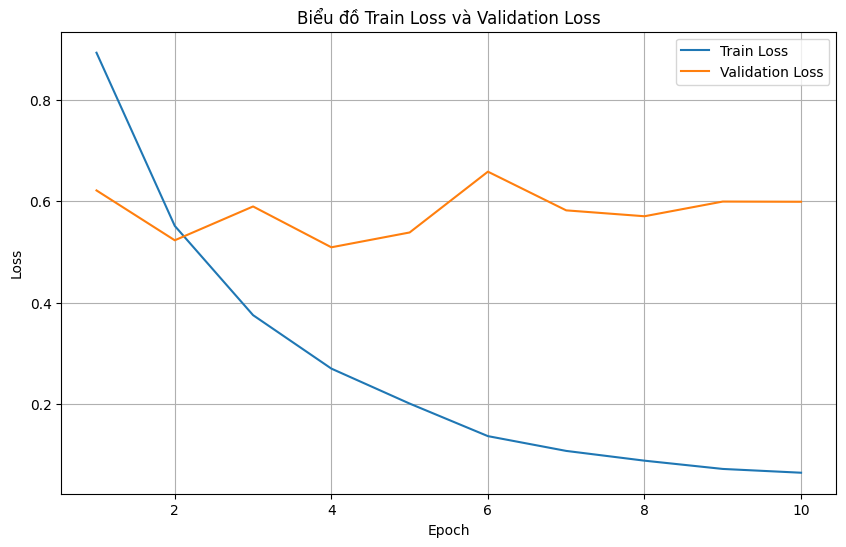

In [51]:
import matplotlib.pyplot as plt

# Trích xuất giá trị thực từ các tensor và chuyển thành danh sách
train_losses_values = [loss for loss in train_losses]
valid_losses_values = [loss for loss in valid_losses]

# Tạo một danh sách các epoch tương ứng với train_losses và valid_losses
epochs = list(range(1, len(train_losses_values) + 1))
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses_values, label='Train Loss')
plt.plot(epochs, valid_losses_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Biểu đồ Train Loss và Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Evalute

In [52]:
model = AutoModelForSequenceClassification.from_pretrained("./best_clean_model_NLI_vietnameseBE")
model.to(device)
model.eval()
test_acc = []

for sentences1, sentences2, labels in tqdm(testDataLoader):
    encoded_input  = tokenizer(sentences2, sentences1, max_length = max_length, padding="max_length", truncation=True,return_tensors='pt')
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)
    token_type_ids  = encoded_input['token_type_ids'].to(device)    
    labels = torch.LongTensor(labels).to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids, labels = labels)
        accuracy = (outputs.logits.argmax(dim=-1) == labels.to(device)).float().mean()
        test_acc.append(accuracy)

test_acc = sum(test_acc) / len(test_acc)
test_acc *= 100
print(f"\n\n 🔎The accuracy of model in test dataset is: {test_acc:.5f}%")
if test_acc > 94.5140:
    print("====== Model said: ======")
    print("Model saild: Thật tuyệt vời!, acc của bạn đang lớn hơn team top 1 UIT (94.5140%) NHƯNG:")
    print("- Bạn có chắc mình trích evidence đủ chính xác:))")
    print('\n"Khi bạn khao khát một điều gì đó, cả vũ trụ sẽ hợp lực giúp bạn đạt được điều đó"\n')
    print("Hãy cố gắng hơn nhóe😝")

  0%|          | 0/24 [00:00<?, ?it/s]



 🔎The accuracy of model in test dataset is: 84.25662%


Acc Cũ bị lỗi chưa lưu: 89.29094%

## Test Predict

In [53]:
# Chuẩn bị hai câu cần dự đoán
sentence1 = "Sau 2 ngày, bạn sẽ nhận được visa điện tử gửi qua email."
sentence2 = "bạn sẽ nhận được visa điện tử gửi qua email trong 2 ngày tới."

# Mã hóa câu 1 và câu 2 bằng tokenizer
'''Nếu dùng VNcoreNLP'''
# encoded_input = tokenizer(preprocessing_text(sentence1), preprocessing_text(sentence2), max_length=max_length, padding="max_length", truncation=True, return_tensors='pt')
'''Nếu không dùng VNcoreNLP'''
encoded_input = tokenizer(sentence2, sentence1, max_length=max_length, padding="max_length", truncation=True, return_tensors='pt')

# Chuyển tensor mã hóa lên thiết bị (GPU hoặc CPU)
input_ids = encoded_input['input_ids'].to(device)
attention_mask = encoded_input['attention_mask'].to(device)
token_type_ids = encoded_input['token_type_ids'].to(device)

# Sử dụng mô hình để dự đoán nhãn
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    predicted_label = outputs.logits.argmax(dim=-1)

# Kết quả dự đoán là predicted_label
print(f"Predicted label: {predicted_label.item()}")

Predicted label: 1


In [54]:
import torch
import torch.nn.functional as F

# Chuẩn bị hai câu cần dự đoán
sentence1 = "Sau 2 ngày, bạn sẽ nhận được visa điện tử gửi qua email."
sentence2 = "Sau đó 20 ngày, bạn sẽ nhận được qua email."


# Mã hóa câu 1 và câu 2 bằng tokenizer
'''Nếu dùng VNcoreNLP'''
# encoded_input = tokenizer(preprocessing_text(sentence1), preprocessing_text(sentence2), max_length=200, padding="max_length", truncation=True, return_tensors='pt')
'''Nếu không dùng VNcoreNLP'''
encoded_input = tokenizer(sentence2, sentence1, max_length=200, padding="max_length", truncation=True, return_tensors='pt')

# Chuyển tensor mã hóa lên thiết bị (GPU hoặc CPU)
input_ids = encoded_input['input_ids'].to(device)
attention_mask = encoded_input['attention_mask'].to(device)
token_type_ids = encoded_input['token_type_ids'].to(device)

# Sử dụng mô hình để dự đoán nhãn
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    logits = outputs.logits
    predicted_label = outputs.logits.argmax(dim=-1)

# Sử dụng hàm softmax để tính xác suất
predicted_probabilities = F.softmax(logits, dim=1)

# Kết quả dự đoán và xác suất là predicted_probabilities
final_predicted = {0: "REFUTED",1: "SUPPORTED", 2: "NEI"}
print(f"Predicted label: {final_predicted[predicted_label.item()]}")
print(f"Predicted probabilities: {predicted_probabilities.tolist()[0]}")

Predicted label: REFUTED
Predicted probabilities: [0.9695208072662354, 0.022243833169341087, 0.008235328830778599]


In [55]:
import torch
import torch.nn.functional as F

# Chuẩn bị hai câu cần dự đoán
'''SUPPORTED'''
sentence1 = "Nhằm hỗ trợ cộng đồng và doanh nghiệp tiêm vaccine phòng bệnh cuối năm cho người lao động, Hệ thống trung tâm tiêm chủng VNVC ưu đãi giá vaccine lớn nhất năm cho tất cả các loại vaccine."
sentence2 = "Giá ưu đãi chỉ còn 299.000 đồng/liều khi tiêm một người, giá chỉ còn 249.000 đồng/liều đối với người thứ 2 đi cùng; khi tiêm từ người thứ 3 đi cùng ưu đãi giá còn 199.000 đồng/liều"

'''REFUTED'''
sentence1 = "Tám bản ghi nhớ được Bộ trưởng Huỳnh Thành Đạt và Bộ trưởng Công nghệ - Truyền thông Lào và Bộ Giáo dục - Thể thao Lào ký nhằm thiết lập, tăng cường quan hệ hợp tác trong nghiên cứu khoa học, ứng dụng, phát triển - chuyển giao công nghệ và đổi mới sáng tạo, góp phần phát triển kinh tế - xã hội của hai nước."
sentence2 = "Hai bản ghi nhớ được Bộ trưởng Huỳnh Thành Đạt và Bộ trưởng Công nghệ - Truyền thông Lào và Bộ Giáo dục - Thể thao Lào ký nhằm thiết lập, tăng cường quan hệ hợp tác trong nghiên cứu khoa học, ứng dụng, phát triển - chuyển giao công nghệ và đổi mới sáng tạo, góp phần phát triển kinh tế - xã hội của hai nước."

'''NEI'''
sentence1 = "Ngày 14/1, Liên đoàn lao động TP HCM tổ chức tiễn 500 công nhân ở các tỉnh miền Trung như Bình Định, Quảng Ngãi, Quảng Nam về quê là một trong các đợt đưa công nhân về nhà ăn Tết của các cấp công đoàn thành phố."
sentence2 = "Ngày 14/1, Liên đoàn lao động TP HCM tổ chức tiễn 500 công nhân ở các tỉnh miền Trung như Bình Định, Quảng Ngãi, Quảng Nam về quê."

'''NEI'''
sentence1 = "Đơn vị cũng triển khai kế hoạch cấp nước và điện an toàn, đảm bảo cấp nước, điện an toàn, ổn định, liên tục."
sentence2 = "Là một thành viên của Tổng công ty Cấp nước Sài Gòn (Sawaco), Công ty Cổ phần Cấp nước Gia Định chịu trách nhiệm cung cấp nước sạch cho khu vực quận Phú Nhuận, Bình Thạnh, một phần quận 3 (phường 12, 13, 14) và Gò Vấp (phường 1)"

'''NEI'''
sentence1 = "Đơn vị cũng triển khai kế hoạch cấp nước và điện an toàn, đảm bảo cấp nước, điện an toàn, ổn định, liên tục."
sentence2 = "Đơn vị cũng triển khai kế hoạch cấp nước an toàn, đảm bảo cấp nước an toàn, ổn định, liên tục."

# Mã hóa câu 1 và câu 2 bằng tokenizer
'''Nếu dùng VNcoreNLP'''
# encoded_input = tokenizer(preprocessing_text(sentence1), preprocessing_text(sentence2), max_length=200, padding="max_length", truncation=True, return_tensors='pt')
'''Nếu không dùng VNcoreNLP'''
encoded_input = tokenizer(sentence2, sentence1, max_length=200, padding="max_length", truncation=True, return_tensors='pt')

# Chuyển tensor mã hóa lên thiết bị (GPU hoặc CPU)
input_ids = encoded_input['input_ids'].to(device)
attention_mask = encoded_input['attention_mask'].to(device)
token_type_ids = encoded_input['token_type_ids'].to(device)

# Sử dụng mô hình để dự đoán nhãn
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    logits = outputs.logits
    predicted_label = outputs.logits.argmax(dim=-1)

# Sử dụng hàm softmax để tính xác suất
predicted_probabilities = F.softmax(logits, dim=1)

# Kết quả dự đoán và xác suất là predicted_probabilities
final_predicted = {0: "REFUTED",1: "SUPPORTED", 2: "NEI"}
print(f"Predicted label: {final_predicted[predicted_label.item()]}")
print(f"Predicted probabilities: {predicted_probabilities.tolist()[0]}")

Predicted label: NEI
Predicted probabilities: [0.010236104018986225, 0.31608831882476807, 0.6736755967140198]
